# Spam or Ham?

This is an example of using machine learning to classify emails as either spam or ham (not spam). Specifically I train a support vector machine on a binary bag-of-words representation of the emails.

The emails used to train this classifier are from [SpamAssassin's Public Corpus](https://spamassassin.apache.org/old/publiccorpus/). I took all the ham files, whether labeled easy or hard, and placed them in a subfolder named `ham`. I did the same thing with the spam files.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 9

## 1 Preprocessing

The two functions below will aid in the processing of the emails when the are used with our model. The first fucntion, `process_email`, take the text of the email and removes the header, HTML, punctuation, etc. The second function, `stemmed_words`, calls `process_email` on the text and then runs a stemmer on the words in the email. `stemmed_words` will be our actual analyzer function for `CountVectorizer`, as you can see below.

In [2]:
from bs4 import BeautifulSoup
from email import message_from_bytes, message_from_string
from nltk.stem.porter import PorterStemmer
from re import sub
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

def process_email(txt):
    """
    Takes an email message and cleans it up for use with CountVectorizer().
    """
    if (type(txt) == bytes):
        msg_email = message_from_bytes(txt)
    else:
        msg_email = message_from_string(txt)
        
    # Only use the message body
    msg = ''
    if msg_email.is_multipart():
        for part in msg_email.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()
                break
    else:
        msg = msg_email.get_payload()
        
    # Conver to all lowercase
    msg = msg.lower()
    
    # Remove line breaks
    msg = sub('\n', ' ', msg)
    msg = sub('\t', ' ', msg)
    
    # Stip HTML
    soup = BeautifulSoup(msg, 'lxml')
    msg = soup.get_text()
    
    # Convert numbers, urls, email addresses, and dollar signs
    msg = sub('[0-9]+', 'number', msg)
    msg = sub('(http|https)://[^\s]*', 'httpaddr', msg)
    msg = sub('[^\s]+@[^\s]+', 'emailaddr', msg)
    msg = sub('[$]+', 'dollar', msg)
    
    # Remove additional punctuation
    table = str.maketrans({key: None for key in punctuation})
    msg = msg.translate(table)
    return msg

stemmer = PorterStemmer()
analyzer = CountVectorizer(decode_error='ignore').build_analyzer()

def stemmed_words(doc):
    """
    Calls the email cleaner and then does stemming. This should be defined as the 'analyzer' in CountVectorizer().
    """
    doc = process_email(doc)
    return (stemmer.stem(w) for w in analyzer(doc))

### 1.1 Load the text files
`load_files` is a nice function for loading large amounts of data. I have the spam emails in `./data/spam` and the ham emails in `./data/ham`. `load_files` automatically classifies the documents based on which folder they are in. When I downloaded the data sets I sorted them based on their labels given by the data set's curator. The emails themselves are stored in the `.data` object with the labels stored in the `.target` object.

In [3]:
from sklearn.datasets import load_files
emails = load_files('data/')

In [4]:
emails.target_names

['ham', 'spam']

In [5]:
emails.target

array([0, 1, 0, ..., 0, 0, 0])

Here's one example of an email before and after it is processed:

In [6]:
emails.data[0]

b"From rpm-list-admin@freshrpms.net  Tue Oct  8 00:10:03 2002\nReturn-Path: <rpm-zzzlist-admin@freshrpms.net>\nDelivered-To: zzzz@localhost.example.com\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby example.com (Postfix) with ESMTP id 9C99F16F17\n\tfor <zzzz@localhost>; Tue,  8 Oct 2002 00:09:58 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Tue, 08 Oct 2002 00:09:58 +0100 (IST)\nReceived: from egwn.net (ns2.egwn.net [193.172.5.4]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g97M3hK18746 for\n    <zzzz-rpm@example.com>; Mon, 7 Oct 2002 23:03:44 +0100\nReceived: from auth02.nl.egwn.net (localhost [127.0.0.1]) by egwn.net\n    (8.11.6/8.11.6/EGWN) with ESMTP id g97Lw2f09321; Mon, 7 Oct 2002 23:58:02\n    +0200\nReceived: from posti.pp.htv.fi (posti.pp.htv.fi [212.90.64.50]) by\n    egwn.net (8.11.6/8.11.6/EGWN) with ESMTP id g97LvNf04590 for\n    <rpm-list@freshrpms.net>; Mon, 7 Oct 2

Here it is after processing, before stemming:

In [7]:
process_email(emails.data[0])

'on tue numbernumbernumber at numbernumber matthias saou wrote   its number untested although the build should be ok the new menu was  added but some configuration files may be better with new or different  defaults    feedback is very welcome  looks good to me just installed it and ran a local scan everything worked smoothly  thanks a bunch    ille skyttä villeskytta at ikifi    rpmlist mailing list  httpaddr   '

Here we test out our `CountVectorizer` that calls our analyzer, stemming the words and representing whether or not a word is present by a `0` or `1` (`binary` = True). This is one version of the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model). We could also represent the actual count, but here we only will indicate if a word is prsent. In the end our vocabulary list will be built up from all of the emails and sorted by word frequency. We'll only keep the most frequent words in our model.

In [8]:
vect = CountVectorizer(decode_error='ignore', binary=True, analyzer=stemmed_words, max_features=2000)
X_tmp = vect.fit_transform([emails.data[0]])
vect.get_feature_names()[:10]

['ad',
 'although',
 'and',
 'at',
 'be',
 'better',
 'build',
 'bunch',
 'but',
 'configur']

The following shows a `1` for every feature, since our vocabulary list only comes from the single point in our data set. So, obviously all words found in this email are present in this email. Again, later our vocabulary list will be built from the entire training set and then applied to each email.

In [9]:
X_tmp.toarray()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

### 1.2 Split data into train and test sets
`train_test_split` shuffles the data by default and splits the data into training and test sets, with 75% of the data in the training set, and 25% in the test set.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(emails.data, emails.target, random_state=0)

### 1.3 Principal component analysis

We want to visualize how well our data transformation does at segregating the data between our two labels. To do that we use principal component analysis to reduce the dimensionality of the data to two. 

Note I am only using the training set here. I don't want any insights I get to have come from the test set, since I may use the insights from PCA in my model which my test set will evaluate.

In [11]:
from sklearn.decomposition import PCA

In [12]:
def plot_pca(a, X, y, target_names):
    for i, target_name in zip([0, 1], target_names):
        a.scatter(X[y == i, 0], X[y == i, 1], alpha=.3, lw=1, label=target_name, marker='.')
    a.legend(loc='best', shadow=False, scatterpoints=1)
    a.set_xlabel('PCA1')
    a.set_ylabel('PCA2')

In [13]:
X_train_pca = {}
features = [50, 100, 200, 500, 1000, 2000]
for i in features:
    vect = CountVectorizer(decode_error='ignore', binary=True, analyzer=stemmed_words, max_features=i)
    X_train_vect = vect.fit_transform(X_train)
    pca = PCA(n_components=2)
    X_train_pca[i] = pca.fit_transform(X_train_vect.toarray())
    print("{0}: {1}".format(i, pca.explained_variance_ratio_))

50: [0.30061008 0.04477264]
100: [0.24868659 0.03480997]
200: [0.21131656 0.03191526]
500: [0.17125659 0.02726248]
1000: [0.14657348 0.02437065]
2000: [0.12767477 0.0220563 ]


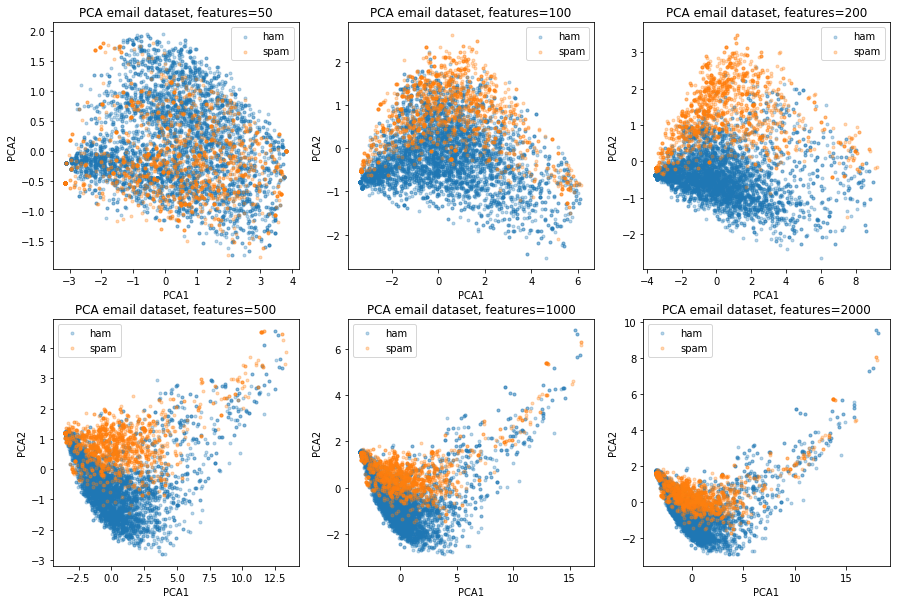

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
for a, j in zip(ax.ravel(), features):
    plot_pca(a, X_train_pca[j], y_train, emails.target_names)
    a.set_title('PCA email dataset, features={0}'.format(j))
plt.show()

In [15]:
X_train_pca = {}
features = [50, 100, 200, 500, 1000, 2000]
for i in features:
    vect = CountVectorizer(decode_error='ignore', binary=False, analyzer=stemmed_words, max_features=i)
    X_train_vect = vect.fit_transform(X_train)
    pca = PCA(n_components=2)
    X_train_pca[i] = pca.fit_transform(X_train_vect.toarray())
    print("{0}: {1}".format(i, pca.explained_variance_ratio_))

50: [0.54132563 0.28332513]
100: [0.53501557 0.28345487]
200: [0.51364404 0.27532017]
500: [0.50659999 0.2740681 ]
1000: [0.50036708 0.27221202]
2000: [0.49605611 0.27057527]


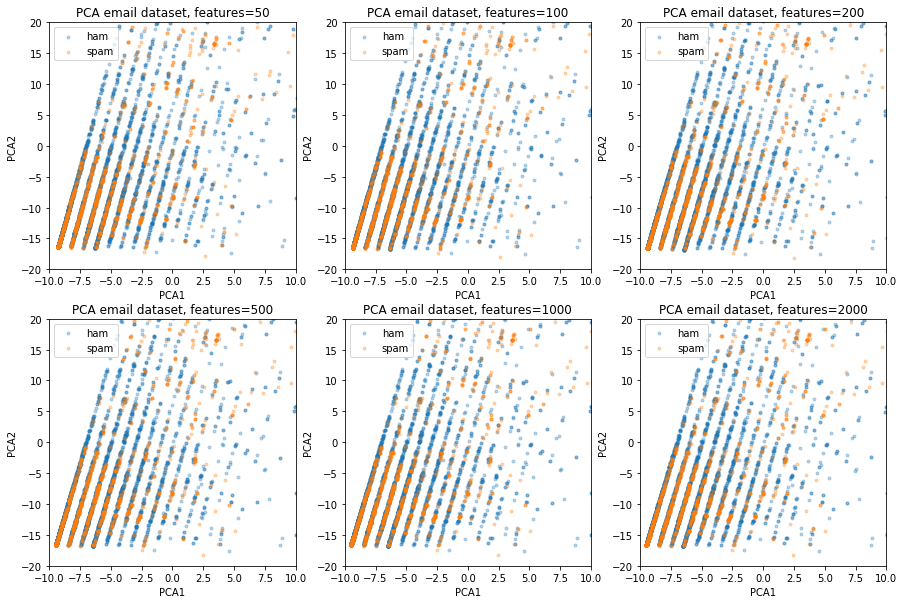

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
for a, j in zip(ax.ravel(), features):
    plot_pca(a, X_train_pca[j], y_train, emails.target_names)
    a.set_title('PCA email dataset, features={0}'.format(j))
    a.set_xlim([-10,10])
    a.set_ylim([-20,20])
plt.show()

#### 1.3.1 Top 10 most frequent words

The most common words don't give much meaning. We could try using tf-idf term weighting (term-frequency times inverse frequency weighting) to help alleviate this problem, or just use the binary vectorization above, since that tends to work well with short documents, like emails.

In [75]:
joy_df = pd.DataFrame(X_train_vect.toarray(), columns=vect.get_feature_names())
selected_words = joy_df.sum(0).sort_values(ascending=False).head(10).index
print(selected_words.tolist())

['the', 'to', 'number', 'and', 'of', 'in', 'is', 'you', 'for', 'it']


## 2 Support Vector Machine

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from joblib import dump, load

### 2.1 Pipeline construction

First we build a `Pipeline` so that every point in the data set (*i.e.*, every email) is passed through the `CountVectorizer` object first and transformed to a bag-of-words representation. We are only going to keep the 2000 most frequently occurring words in the training set, but we could adjust this as a hyperparameter if we desired. Some of the emails have some decoding issues (only a few) so we'll just ignore those. You can see once again we're specifying `binary=True`, meaning we only are counting if a vocabulary word is in the email, not the number of occurrences. We specify the `analyzer` which we made above which is responsible for *both* the preprocessing and tokenization of the words.

After emails are processed by `CountVectorizer` they are then fed into `SVC`, the support vector classifer. We are specifying a linear kernel here, but we could easily make that a hyper parameter to do a grid search on below.

Using a pipeline has the advantage that information from the validation set doesn't bleed over to the train set in the cross validation. For example, if we first transformed the entire training set into a feature vector and then ran cross validation, the vocabulary list, and thus the features would have been built on the entire training set (including the validation set). So we might be inflating the validation set's performance if we did our preprocessing outside of the pipeline.

In [16]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=2000, 
                             decode_error='ignore',
                             binary=True,
                             analyzer=stemmed_words)),
    ('svc', SVC(kernel='linear')),
])

### 2.2 Grid search
Here we construct a grid search over the `C` parameter used with the support vector classifer. This is the regularization parameter, also known as the penalty parameter. Smaller values mean more regularization in this case. We run the search on the training set alone and save the model to disk.

This grid search also does cross-validation, meaning the training data set is split up into two parts, which will become our new training and validation sets for this purpose. I'm using five-fold CV, meaning 4/5 of the training data is going to be treated as a training set, and the other 1/5 is the validation set which we test the model on. For each set of hyperparameters we do this five times, since the data will be split up into fifths. In the end we'll find the value of `C` that produces the best estimator and that will be used in our final test with the original test set.

I'm using the F1 score as the quantity we want to base our decision on which estimator is 'best'.

In [17]:
tuned_parameters = [{'svc__C': np.logspace(-2,2,5)}]
clf = GridSearchCV(pipeline, param_grid=tuned_parameters, 
                   scoring="f1", return_train_score=True,
                   verbose=10, n_jobs=3, cv=5)
clf.fit(X_train, y_train)
dump(clf, 'clf.gz')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] ............ svc__C=0.01, score=0.9041450777202072, total=  59.6s
[CV] svc__C=0.01 .....................................................
[CV] ............ svc__C=0.01, score=0.9069148936170213, total= 1.6min
[CV] svc__C=0.01 .....................................................


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.7min


[CV] ............ svc__C=0.01, score=0.9090909090909092, total= 1.7min
[CV] svc__C=0.1 ......................................................
[CV] ............ svc__C=0.01, score=0.8937823834196892, total= 1.7min
[CV] svc__C=0.1 ......................................................
[CV] ............. svc__C=0.01, score=0.917989417989418, total= 1.8min
[CV] svc__C=0.1 ......................................................
[CV] ............. svc__C=0.1, score=0.9300518134715026, total= 1.6min
[CV] svc__C=0.1 ......................................................
[CV] ............. svc__C=0.1, score=0.9088575096277279, total= 1.7min
[CV] svc__C=0.1 ......................................................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  8.2min


[CV] .............. svc__C=0.1, score=0.916883116883117, total= 1.6min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=0.1, score=0.8979591836734694, total= 1.6min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=0.1, score=0.9300518134715025, total= 1.5min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.9321148825065275, total= 1.6min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.9074550128534704, total= 1.3min


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 11.4min


[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.9042145593869733, total= 1.7min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.9170984455958548, total= 1.7min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.9300518134715025, total= 1.6min
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.9295039164490861, total= 1.5min
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.8960205391527598, total= 1.6min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=10.0, score=0.909560723514212, total= 1.6min
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=10.0, score=0.9056122448979591, total= 1.7min
[CV] s

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 19.6min


[CV] ............ svc__C=10.0, score=0.9196891191709844, total= 1.7min
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.9295039164490861, total= 1.5min
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.8960205391527598, total= 1.4min
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=100.0, score=0.909560723514212, total= 1.0min


[Parallel(n_jobs=3)]: Done  23 out of  25 | elapsed: 22.1min remaining:  1.9min


[CV] ........... svc__C=100.0, score=0.9056122448979591, total= 1.6min
[CV] ........... svc__C=100.0, score=0.9184993531694695, total=  57.5s


[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 23.5min finished


['clf.gz']

### 2.3 Validation curve

Below we plot the validation curve, showing the average train and validation scores from the cross validation as a function of the penalty parameter `C`. As you can see there is a peak in the validation score at `C=1.0`. Any value greater than that means we would be overfitting (note how the training score increases but the validation score decreases), and values lower than that are underfitting (boht scores decrease as `C` gets smaller).

In [18]:
clf = load('clf.gz')
results = pd.DataFrame(clf.cv_results_)

In [19]:
clf.best_params_

{'svc__C': 1.0}

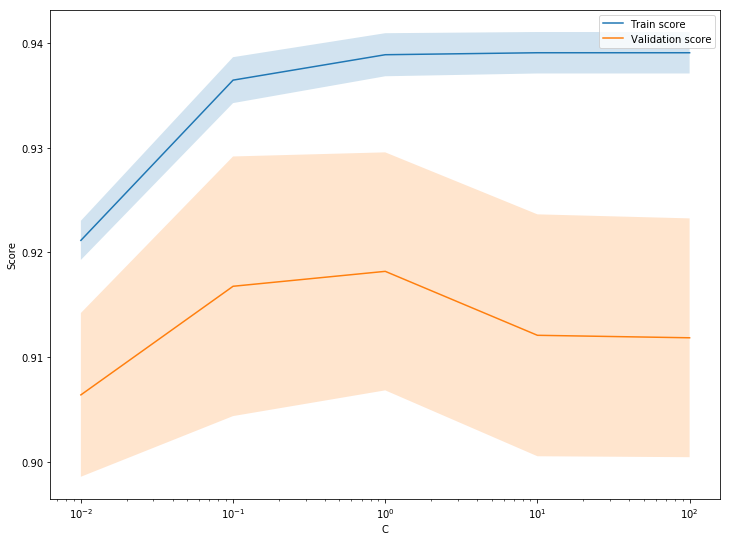

In [20]:
results.plot('param_svc__C', 'mean_train_score', label='Train score')
results.plot('param_svc__C', 'mean_test_score', label='Validation score', ax=plt.gca())
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], 
                 alpha=0.2)
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], 
                 alpha=0.2)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend()
plt.show()

### 2.4 Learning curve
Here we use the best estimator found in the grid search above to calculate the performance of the model as a function of the size of the training set.

In [21]:
from sklearn.model_selection import learning_curve

In [22]:
lc_results = learning_curve(clf.best_estimator_, X_train, y_train,
                            cv=5, n_jobs=3, train_sizes=np.linspace(.1, 1.0, 5),
                            verbose=10, scoring='f1')
dump(lc_results, 'learning_curve.gz')

[learning_curve] Training set sizes: [ 560 1822 3084 4346 5609]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.7918622848200313, total=  25.9s
[CV]  ................................................................
[CV] ....................... , score=0.8970013037809648, total=  42.8s
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:   59.6s remaining: 11.4min


[CV] ....................... , score=0.9112271540469974, total=  46.4s
[CV]  ................................................................
[CV] ....................... , score=0.8545918367346939, total=  27.2s
[CV]  ................................................................
[CV] ....................... , score=0.9258777633289986, total= 1.1min
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done   5 out of  25 | elapsed:  2.5min remaining: 10.2min


[CV] ........................ , score=0.878048780487805, total=  43.3s
[CV]  ................................................................
[CV] ....................... , score=0.9321148825065275, total= 1.4min
[CV]  ................................................................
[CV] ....................... , score=0.8960205391527598, total=  41.7s
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:  3.9min remaining:  8.2min


[CV] ....................... , score=0.8647959183673469, total=  29.2s
[CV]  ................................................................
[CV] ....................... , score=0.9048843187660668, total=  59.4s
[CV]  ................................................................
[CV] ....................... , score=0.8950131233595799, total=  45.4s
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done  11 out of  25 | elapsed:  5.7min remaining:  7.2min


[CV] ....................... , score=0.8979057591623036, total=  35.9s
[CV]  ................................................................
[CV] ....................... , score=0.9074550128534704, total= 1.5min
[CV]  ................................................................
[CV] ........................ , score=0.860759493670886, total=  26.9s
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:  6.8min remaining:  5.4min


[CV] ....................... , score=0.9109677419354839, total= 1.0min
[CV]  ................................................................
[CV] ....................... , score=0.8808290155440415, total=  32.2s
[CV]  ................................................................
[CV] ....................... , score=0.9170984455958548, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done  17 out of  25 | elapsed:  8.1min remaining:  3.8min


[CV] ....................... , score=0.8874514877102199, total=  54.9s
[CV]  ................................................................
[CV] ...................................... , score=0.9, total= 1.1min
[CV]  ................................................................
[CV] ....................... , score=0.8888888888888888, total=  26.5s
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:  9.8min remaining:  2.4min


[CV] ....................... , score=0.9109947643979058, total=  38.4s
[CV]  ................................................................
[CV] ....................... , score=0.9042145593869733, total= 1.3min
[CV]  ................................................................
[CV] ....................... , score=0.9126466753585397, total=  44.1s


[Parallel(n_jobs=3)]: Done  23 out of  25 | elapsed: 11.1min remaining:   57.8s


[CV] ....................... , score=0.9192708333333335, total= 1.1min
[CV] ....................... , score=0.9300518134715025, total= 1.0min


[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 12.3min finished


['learning_curve.gz']

In [23]:
def plot_learning_curve(lc_results):
    train_sizes = lc_results[0]
    train_scores = lc_results[1]
    test_scores = lc_results[2]
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Test score")

    plt.legend(loc="best")
    plt.xlabel('Number of samples')
    plt.ylabel("F1 score")
    plt.show()

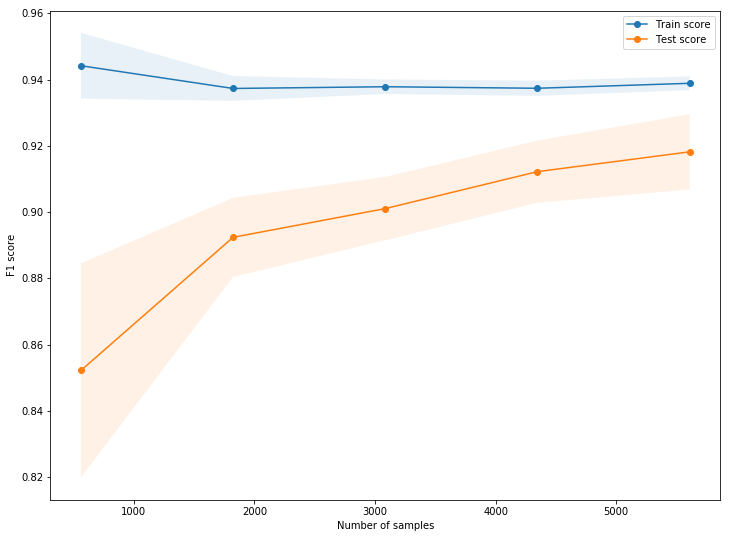

In [24]:
plot_learning_curve(load('learning_curve.gz'))

### 2.5 Classification report

Precision: 

$ P = \frac{T_{p}}{T_{p} + F_{p}} $

Recall:

$ R = \frac{T_{p}}{T_{p} + F_{n}} $

F1 score:

$ F1 = 2\frac{PR}{P+R}$

In [25]:
from sklearn.metrics import classification_report

In [26]:
print("Training accuracy: {0:.3}".format(clf.score(X_train, y_train)))

Training accuracy: 0.939


In [29]:
y_pred = clf.predict(X_train)

In [30]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.95      0.98      5195
          1       0.88      1.00      0.94      1817

avg / total       0.97      0.97      0.97      7012



## 3 Top predictors of spam

Shown below, there is an issue of our model picking up words that are specific to this data set. `spamassassinsight` seems to be referring to `spamassassin-sightings`, an e-mail list that some users refer to in these specific emails. If we were to generalize our model, we would need a more general vocabulary list, drawn from a more diverse data set, or we can adjust `CountVectorizer` in the pipeline (or do a grid search over some additional hyperparameters).

In [43]:
def plot_important_words(coef, names, label, n=10):
    coef_argsorted = np.argsort(coef)
    feature_names_array = np.array(names)
    words = []
    values = []
    if label == 'spam':
        for i in range(-n,0):
            words.append(names[coef_argsorted[i]])
            values.append(coef[coef_argsorted[i]])
    else:
        for i in range(n, 0, -1):
            words.append(names[coef_argsorted[i]])
            values.append(coef[coef_argsorted[i]])

    y = np.arange(n)
    plt.barh(y, values)
    plt.yticks(y, words)
    plt.xlabel('Coefficient')
    plt.ylabel('Word')
    plt.title(label)
    plt.show()

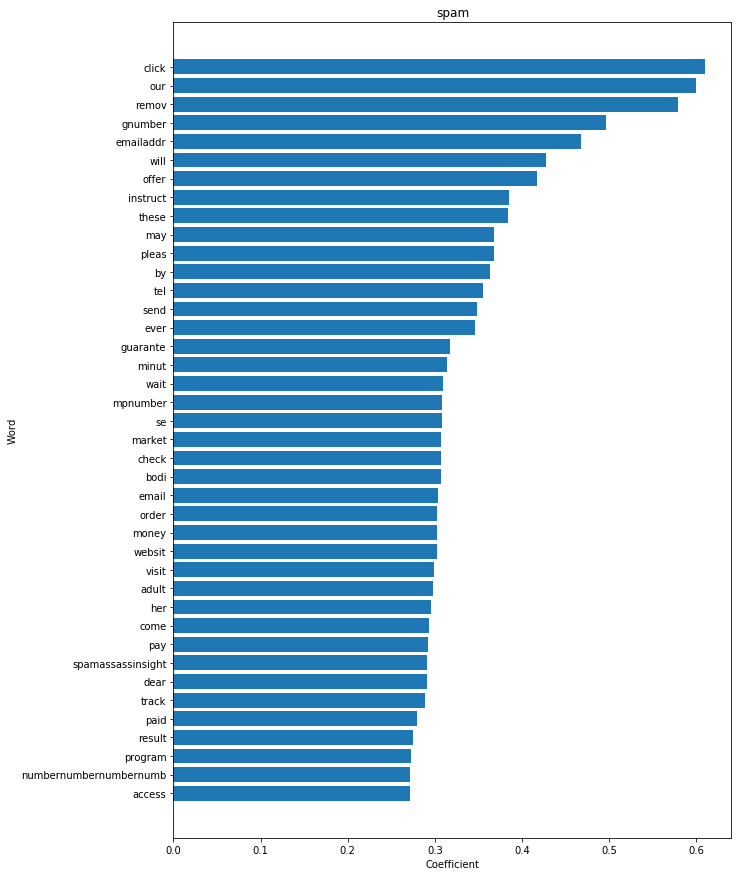

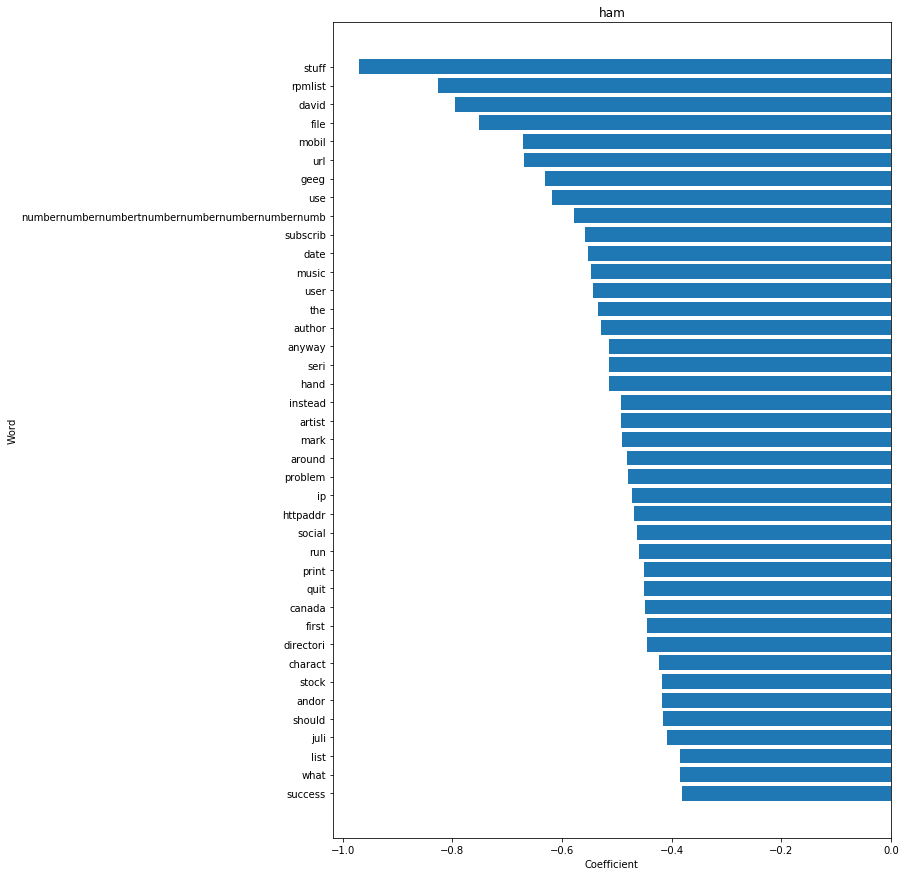

In [53]:
plt.figure(figsize=(10,15))
plot_important_words(clf.best_estimator_.named_steps['svc'].coef_.toarray()[0], 
                     clf.best_estimator_.named_steps['vect'].get_feature_names(),
                    'spam', 40)

plt.figure(figsize=(10,15))
plot_important_words(clf.best_estimator_.named_steps['svc'].coef_.toarray()[0], 
                     clf.best_estimator_.named_steps['vect'].get_feature_names(),
                    'ham', 40)

## 4 Test set evaluation

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, roc_auc_score

In [32]:
print("Test accuracy: {0:.3}".format(clf.score(X_test, y_test)))

Test accuracy: 0.892


### 4.1 Classification report

In [33]:
y_pred = clf.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.93      0.96      1757
          1       0.82      0.98      0.89       581

avg / total       0.95      0.94      0.94      2338



### 4.2 Precision-recall curve

Precision-recall curves show the changes in precision and recall for different probability thresholds. That is, when we predict whether or not an email is spam, we get a probabliity. We could classify an email to be spam if `p >= 0.5` and not spam otherwise, but we can change that threshold.

#### Average precision:

$ AP = \sum_{n}(R_{n} - R_{n-1})P_{n} $

In [35]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

Area under the precision-recall curve using the trapezoidal rule.

In [36]:
auc_score = roc_auc_score(y_test, y_score)

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

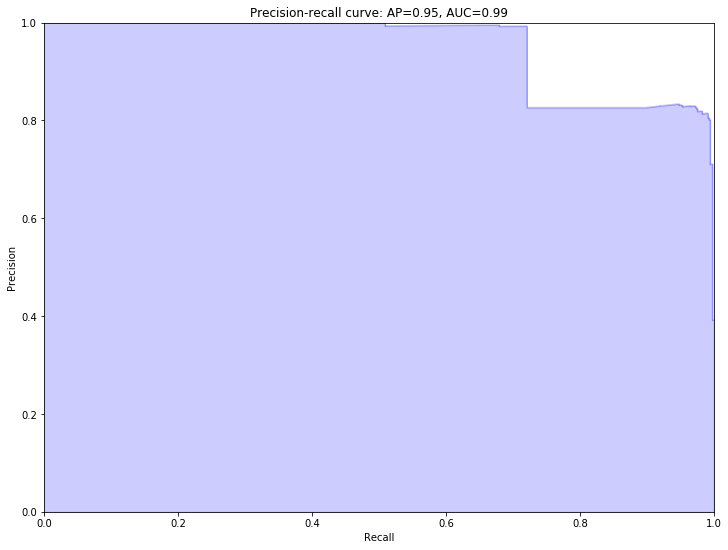

In [38]:
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve: AP={0:0.2f}, AUC={1:0.2f}'.format(average_precision, auc_score))
plt.show()

### 4.3 Confusion matrix

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [41]:
cnf_matrix = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[0.92942516 0.07057484]
 [0.02409639 0.97590361]]


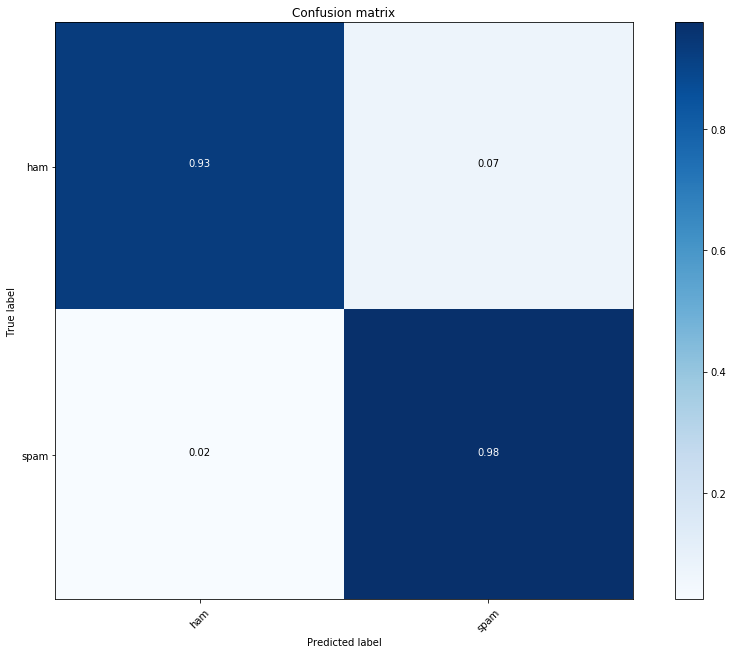

In [54]:
plot_confusion_matrix(cnf_matrix, emails.target_names, True)